# Example on how to load data and analyse sub-grid variability and anomaly

By Lukas Brunner (lukas.brunner@uni-hamburg.de)

In [1]:
import os
import intake
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import healpix_functions as hf
from healpix_plot import get_listed_colormap, get_diverging_colormap, hp_plot, plot_polygon

## Navigating the intake catalog

In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
ifs = cat['IFS']
list(ifs)

['IFS_2.8-FESOM_5-production-deep-off',
 'IFS_2.8-FESOM_5-production',
 'IFS_9-FESOM_5-production',
 'IFS_9-FESOM_5-production-hist',
 'IFS_4.4-FESOM_5-cycle3',
 'IFS_9-FESOM_5-cycle3',
 'IFS_9-NEMO_25-cycle3',
 'IFS_9-coarse_surf-cycle3',
 'IFS_28-NEMO_25-cycle3',
 'IFS_28-FESOM_25-cycle3',
 'IFS_4.4-FESOM_5-cycle3-nofastdata',
 'IFS_4.4-FESOM_5-cycle3-fastdata',
 'IFS_9-FESOM_5-production-hist-coupspinup',
 'IFS_9-FESOM_5-production-hist-coupspinup-deepon',
 'IFS_grids']

In [4]:
ifs28o = ds = cat['IFS']['IFS_2.8-FESOM_5-production-deep-off']
list(ifs28o)

['2D_hourly_healpix2048',
 '3D_hourly_healpix2048',
 '3D_hourly_healpix2048_snow',
 '2D_daily_healpix512_ocean',
 '3D_daily_healpix512_ocean',
 '2D_monthly_healpix2048',
 '2D_hourly_healpix128',
 '3D_hourly_healpix128',
 '3D_hourly_healpix128_snow',
 '2D_daily_healpix128_ocean',
 '3D_daily_healpix128_ocean',
 '2D_monthly_healpix128',
 '3D_hourly_0.25deg',
 '2D_hourly_0.25deg',
 '3D_hourly_0.25deg_snow',
 '2D_monthly_0.25deg']

In [5]:
ds = ifs28o['2D_hourly_healpix2048'].to_dask()
ds

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 10201, value: 50331648)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(50331648,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(50331648,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-01 2020-01-01T01:00:00 ... 2021-03-01
Dimensions without coordinates: value
Data variables: (12/63)
    100si    (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    10si     (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    ...       ...
    tp       (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    tprate   (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    tsrc     (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
    ttrc     (time, value) float64 dask.array<chunksize=(1, 50331648), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

## Subsetting the data and getting basic HEALPix information

In [6]:
date = '2020-01-01'
tas = ds['2t'].sel(time=date)
tas = tas.resample(time='1D').mean().squeeze()
tas.load()

<xarray.DataArray '2t' (value: 50331648)>
array([299.92586644, 299.93065357, 299.93927288, ..., 299.60341104,
       299.62310823, 299.60456403])
Coordinates:
    lat      (value) float64 0.01865 0.0373 0.0373 ... -0.0373 -0.0373 -0.01865
    lon      (value) float64 45.0 45.02 44.98 45.0 ... 315.0 315.0 315.0 315.0
    time     datetime64[ns] 2020-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             50331648
    typeOfLevel:                heightAboveGround
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfName:                     air_temperature
    cfVarName:                  t2m
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [7]:
# zoom level from number of grid cells
hp.npix2order(tas.size)

11

In [8]:
# change zoom level
tas_z6 = hf.aggregate_grid_xr(tas, 6)
tas_z6

<xarray.DataArray '2t' (value: 49152)>
array([300.03845914, 300.05752555, 300.44161223, ..., 299.8937612 ,
       299.21786544, 299.76112935])
Coordinates:
    time     datetime64[ns] 2020-01-01
Dimensions without coordinates: value

## Simple mapplots

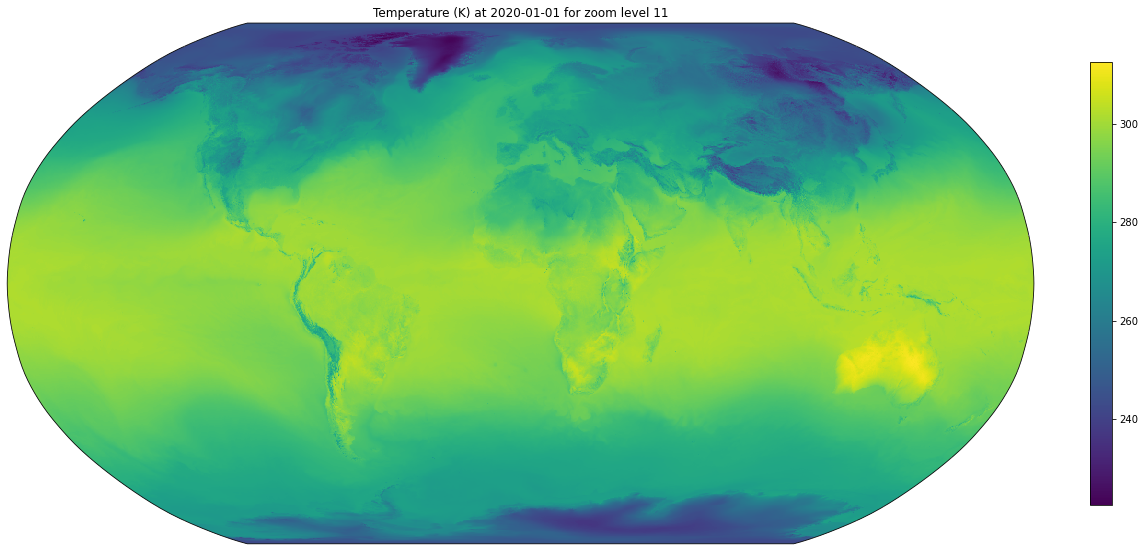

In [9]:
fig, ax, map_ = hp_plot(tas)
ax.set_title(f'Temperature (K) at {date} for zoom level 11');

In [10]:
# hp_plot(tas_z6)
# ax.set_title(f'Temperature (K) at {date} for zoom level 6');

## Calculating the subgrid variability

A measure of how much spatial variability is lost at coarser grids spacings compared to finer grid spacing.

In [11]:
tas_std = hf.aggregate_grid_xr(tas, z_out=6, method='std')

In [12]:
# hp_plot(tas_std, cmap='magma_r')
# ax.set_title(f'Temperature (K) subgrid variability at {date}: zoom level 11 -> 6');

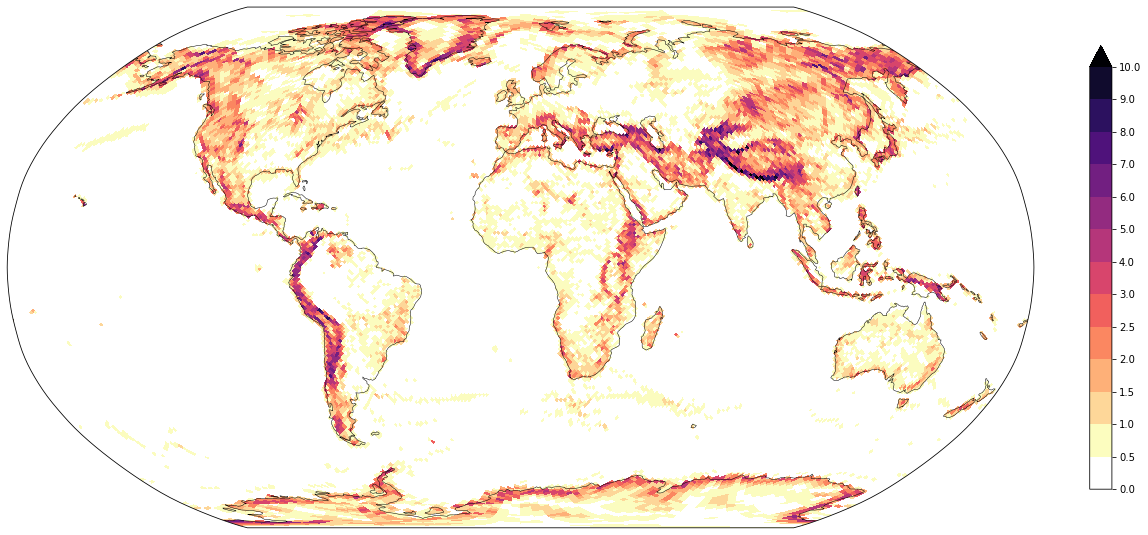

In [13]:
# customizing the plot

levels = [0, .5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
extend = 'max'
kwargs = dict(
    cmap=get_listed_colormap(levels, 'magma_r', return_colors=True, white='first', extend=extend),
    levels=levels, 
    extend=extend,
    add_coastlines=True,
)
hp_plot(tas_std, **kwargs)
ax.set_title(f'Temperature (K) subgrid variability at {date}: zoom level 11 -> 6');

## Calculating the subgrid anomaly

For each grid cell within a given coarser grid cell calculate the difference fine - coarse.

In [14]:
tas_anom = hf.subgrid_anomaly_xr(tas, z_coarse=6)

In [18]:
# levels = np.arange(-5, 5.1, .5)
# extend = 'both'
# kwargs = dict(
#     cmap=get_diverging_colormap(levels, return_colors=True, extend=extend),
#     levels=levels, 
#     extend=extend,
#     add_coastlines=True,
#     coastline_kwargs=dict(
#         color='k',
#         lw=.5,
#     ),
#     cbar_kwargs={'ticks': levels[::2]},
# )
# hp_plot(tas_anom, **kwargs)
# ax.set_title(f'Temperature (K) subgrid anomaly at {date}: zoom level 11 minus 6');

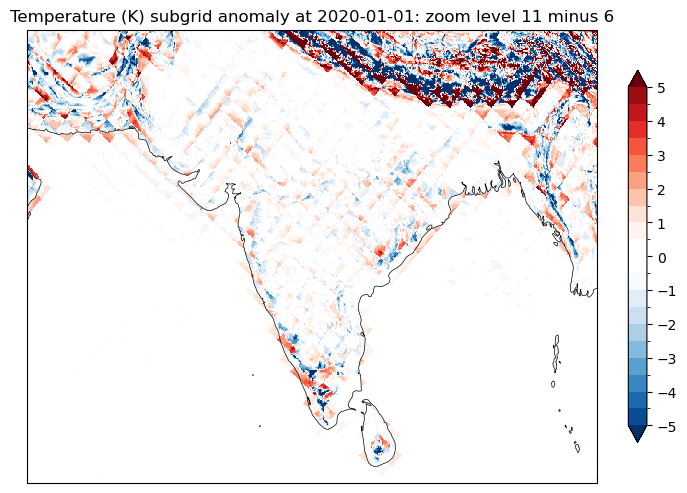

In [19]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.Robinson()})
ax.set_extent([60, 95, 5, 30])
hp_plot(tas_anom, ax=ax, **kwargs)
ax.set_title(f'Temperature (K) subgrid anomaly at {date}: zoom level 11 minus 6');